# Combination of FNN Models

## Imports

In [2]:

import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt


from scipy import stats
from keras.layers import Concatenate, Lambda
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, Input, Multiply, Activation, BatchNormalization, Flatten

## Load Datasets

In [3]:
# read json file into a df
df = pd.read_json('c:/Users/User/Desktop/DATA/01 Labeled CSI DATA/5th_try_labeled_csi_data.json')
print(df.head())

C:\Users\User\AppData\Local\Temp\ipykernel_10832\4233416732.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df = pd.read_json('c:/Users/User/Desktop/DATA/01 Labeled CSI DATA/5th_try_labeled_csi_data.json')


             datetime      cfo   snr  \
0 2024-05-29 09:04:00  25215.5  10.8   
1 2024-05-29 09:04:00  18145.7   6.4   
2 2024-05-29 09:04:00  28780.0   6.5   
3 2024-05-29 09:04:00  26879.3  10.2   
4 2024-05-29 09:04:00  22685.4   9.6   

                                                real  \
0  [-0.079, -0.111, -0.139, -0.138, -0.132, -0.13...   
1  [0.057, 0.041, 0, 0.014, 0.023, 0.068, 0.10200...   
2  [0.039, 0.018000000000000002, -0.002, 0.044, 0...   
3  [-0.068, -0.055, -0.028, -0.061, -0.096, -0.11...   
4  [-0.055, -0.046, -0.037, -0.082, -0.127, -0.13...   

                                                imag  \
0  [-0.035, -0.018000000000000002, 0.014, 0.041, ...   
1  [0.108, 0.168, 0.225, 0.192, 0.158, 0.137, 0.1...   
2  [-0.115, -0.115, -0.112, -0.105, -0.08, -0.135...   
3  [-0.008, -0.041, -0.063, -0.131, -0.198, -0.15...   
4  [0.122, 0.101, 0.08, 0.077, 0.049, 0.104000000...   

                                            real_new  \
0  [-0.531, 0.322, -0.016, -0

In [4]:
df_test = pd.read_json("C:/Users/User/Desktop/DATA/ZB107 TEST/labeled_ZB107_TEST_data.json")
print(df_test.head())

             datetime      cfo  snr  \
0 2024-07-09 10:08:00  30576.1  3.7   
1 2024-07-09 10:08:00  14354.1  4.0   
2 2024-07-09 10:08:00  21100.4  4.7   
3 2024-07-09 10:08:00  18725.2  6.3   
4 2024-07-09 10:08:00  22891.8  6.3   

                                                real  \
0  [0.08700000000000001, 0.136, 0.165, 0.221, 0.2...   
1  [-0.123, -0.077, -0.032, -0.07200000000000001,...   
2  [0.107, 0.167, 0.18, 0.184, 0.163, 0.173000000...   
3  [-0.081, -0.063, -0.032, -0.048, -0.005, -0.15...   
4  [-0.01, -0.054, -0.092, -0.163, -0.225, -0.052...   

                                                imag  \
0  [-0.17, -0.124, -0.066, -0.041, 0.003, 0.08, 0...   
1  [-0.042, -0.069, -0.07, -0.058, -0.022, 0.134,...   
2  [-0.135, -0.061, 0.036000000000000004, -0.032,...   
3  [-0.003, 0.035, 0.055, -0.009000000000000001, ...   
4  [0.006, 0.006, -0.029, -0.008, 0.047, -0.129, ...   

                                            real_new  \
0  [0.608, -0.194, -0.0430000000000

C:\Users\User\AppData\Local\Temp\ipykernel_10832\3620723908.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_test = pd.read_json("C:/Users/User/Desktop/DATA/ZB107 TEST/labeled_ZB107_TEST_data.json")


## Preprocessing Main Dataset

In [5]:
# Convert DataFrame to a JSON string
json_string = df.to_json(orient='records')

# Load JSON string into a list of dictionaries
data = json.loads(json_string)

# Filter out dictionaries where the key "class" has a value of 5
filtered_data = [d for d in data if d.get("class") != 5]

# Convert the JSON data to a DataFrame
df = pd.DataFrame(filtered_data)

<class 'numpy.int64'>
<class 'numpy.int64'>
class
3    18774
2    16750
1    15845
4    15749
0    11730
Name: count, dtype: int64


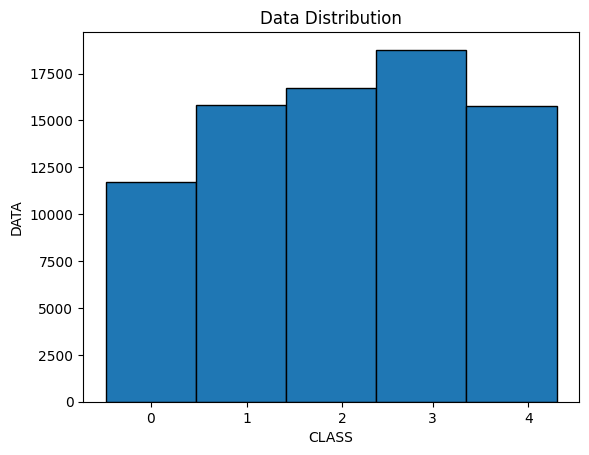

In [6]:
# keep only the columns we need, real imag and class
df = df[['real','imag','snr','powr','class']]

# convert class to numeric
print(type(df['class'][0]))
df['class'] = pd.to_numeric(df['class'])
print(type(df['class'][0]))

# check the distribution of the classes
print(df['class'].value_counts())
y = df['class'].values

# check the distribution of the classes

labels= ['0','1','2','3','4']
plt.hist(y, bins=5, edgecolor='black')# bins is the number of bins you want to divide the data into
plt.xticks([0.4, 1.25, 2.1, 2.9, 3.75], labels) # Set the x-axis ticks at the center of bins  
plt.xlabel('CLASS')
plt.ylabel('DATA')
plt.title('Data Distribution')

plt.show()

# convert real and imaginary to list
df_real =  pd.DataFrame(df.real.to_list())
df_imag =  pd.DataFrame(df.imag.to_list())
df_snr =  pd.DataFrame(df.snr.to_list())
df_powr =  pd.DataFrame(df.powr.to_list())



In [9]:
print(df)
print(df_real)
print(df_imag)
print(df_snr)
print(df_powr)

# concat the real and imag dataframes 
df_final = pd.concat([df_real, df_imag, df_snr, df_powr, df['class']], axis=1)

print(df.head())
print(df_final)

print(df_final.shape)

# map the classes 1,2,3,4 to 1 
y_presence = df_final['class'].map({0:0, 1:1, 2:1, 3:1, 4:1})

# map the classes 1,2,3,4 to 1 
y_occupancy = df_final['class'].map({0:0, 1:0, 2:1, 3:1, 4:2})

# map the classes 1,2,3,4 to 1 
y_counting = df_final['class'].map({0:0, 1:1, 2:2, 3:3, 4:4})


X = df_final.drop('class', axis=1).values 


print(y_presence.value_counts())
print(y_occupancy.value_counts())
print(y_counting.value_counts())
print(X.shape)
print(y_presence.shape)
print(y_occupancy.shape)
print(y_counting.shape)
print(X)
print(y_presence)
print(y_occupancy)
print(y_counting)

                                                    real  \
0      [-0.079, -0.111, -0.139, -0.138, -0.132, -0.13...   
1      [0.057, 0.041, 0, 0.014, 0.023, 0.068, 0.102, ...   
2      [0.039, 0.018, -0.002, 0.044, 0.084, 0.036, -0...   
3      [-0.068, -0.055, -0.028, -0.061, -0.096, -0.11...   
4      [-0.055, -0.046, -0.037, -0.082, -0.127, -0.13...   
...                                                  ...   
78843  [0.086, -0.297, -0.182, -0.204, -0.056, -0.019...   
78844  [-0.125, -0.081, -0.013, -0.094, -0.138, -0.15...   
78845  [-0.026, -0.059, -0.031, -0.059, -0.036, -0.02...   
78846  [-0.008, -0.026, -0.053, -0.034, 0.003, 0.067,...   
78847  [0.056, 0.028, -0.014, -0.055, -0.078, -0.047,...   

                                                    imag   snr  powr  class  
0      [-0.035, -0.018, 0.014, 0.041, 0.069, 0.066, 0...  10.8 -25.9      1  
1      [0.108, 0.168, 0.225, 0.192, 0.158, 0.137, 0.1...   6.4 -25.8      0  
2      [-0.115, -0.115, -0.112, -0.105, -0.08

In [10]:
print(y_presence.shape)
print(y_occupancy.shape)
print(y_counting.shape)

(78848,)
(78848,)
(78848,)


## Preprocessing Proof-of-Concept Dataset

<class 'numpy.int64'>
<class 'numpy.int64'>
class
2    284
0    271
1    161
3    159
4     43
Name: count, dtype: int64


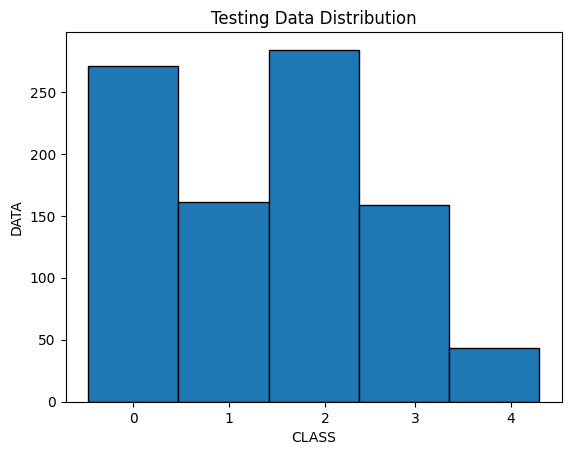

In [11]:
# keep only the columns we need, real imag and class
df_test = df_test[['real','imag','snr', 'best_coeffs_idx', 'powr','class']]

# convert class to numeric
print(type(df_test['class'][0]))
df_test['class'] = pd.to_numeric(df_test['class'])
print(type(df_test['class'][0]))

# check the distribution of the classes
print(df_test['class'].value_counts())
y_test = df_test['class'].values

# check the distribution of the classes

labels= ['0','1','2','3','4']
plt.hist(y_test, bins=5, edgecolor='black')# bins is the number of bins you want to divide the data into
plt.xticks([0.4, 1.25, 2.1, 2.9, 3.75], labels) # Set the x-axis ticks at the center of bins  
plt.xlabel('CLASS')
plt.ylabel('DATA')
plt.title('Testing Data Distribution')

plt.show()


# convert real and imaginary to list
df_real_test = pd.DataFrame(df_test.real.to_list())
df_imag_test = pd.DataFrame(df_test.imag.to_list())
df_snr_test = pd.DataFrame(df_test.snr.to_list())
df_powr_test = pd.DataFrame(df_test.powr.to_list())
df_best_coeffs_idx_test = pd.DataFrame(df_test.best_coeffs_idx.to_list())

In [12]:
print(df_test)
print(df_real_test)
print(df_imag_test)
print(df_snr_test)
print(df_powr_test)

# concat the real and imag dataframes 
df_final_test = pd.concat([df_real_test, df_imag_test, df_snr_test, df_powr_test, df_test['class']], axis=1)

print(df_test.head())
print(df_final_test)

print(df_final_test.shape)

# map the classes 1,2,3,4,5 to 1 
y_test_poc_presence = df_final_test['class'].map({0:0, 1:1, 2:1, 3:1, 4:1})
y_test_poc_occupancy = df_final_test['class'].map({0:0, 1:0, 2:1, 3:1, 4:2})
y_test_poc_counting = df_final_test['class'].map({0:0, 1:1, 2:2, 3:3, 4:4})

X_test_poc = df_final_test.drop('class', axis=1).values 

print(y_test_poc_presence)
print(y_test_poc_occupancy)
print(y_test_poc_counting)

print(X_test_poc.shape)
print(X_test_poc)


                                                  real  \
0    [0.08700000000000001, 0.136, 0.165, 0.221, 0.2...   
1    [-0.123, -0.077, -0.032, -0.07200000000000001,...   
2    [0.107, 0.167, 0.18, 0.184, 0.163, 0.173000000...   
3    [-0.081, -0.063, -0.032, -0.048, -0.005, -0.15...   
4    [-0.01, -0.054, -0.092, -0.163, -0.225, -0.052...   
..                                                 ...   
913  [-0.111, -0.122, -0.121, 0.055, 0.068, -0.0510...   
914  [-0.088, -0.112, -0.136, -0.135, -0.099, -0.11...   
915  [-0.035, -0.081, -0.105, -0.151, -0.151, -0.06...   
916  [-0.202, -0.178, -0.136, -0.117, 0.093, -0.023...   
917  [0.005, -0.062, -0.073, 0.011, 0.074, 0.148, -...   

                                                  imag  snr  \
0    [-0.17, -0.124, -0.066, -0.041, 0.003, 0.08, 0...  3.7   
1    [-0.042, -0.069, -0.07, -0.058, -0.022, 0.134,...  4.0   
2    [-0.135, -0.061, 0.036000000000000004, -0.032,...  4.7   
3    [-0.003, 0.035, 0.055, -0.009000000000000001, 

## Feedforward Neural Network

### FNN Preprocessing

In [11]:
# set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# first split the data into training (80%) and test (10%) set
X_presence_train, X_presence_test1, y_presence_train, y_presence_test1 = train_test_split(X_test_poc, y_test_poc_presence)
# first split the data into training (80%) and test (10%) set
X_occupancy_train, X_occupancy_test1, y_occupancy_train, y_occupancy_test1 = train_test_split(X_test_poc, y_test_poc_occupancy)
# first split the data into training (80%) and test (10%) set
X_counting_train, X_counting_test1, y_counting_train, y_counting_test1 = train_test_split(X_test_poc, y_test_poc_counting)

# then split the training set further into training (80%) and validation (20%) set
X_presence_train, X_presence_val, y_presence_train, y_presence_val = train_test_split(X, y_presence, test_size=0.2)
# then split the training set further into training (80%) and validation (20%) set
X_occupancy_train, X_occupancy_val, y_occupancy_train, y_occupancy_val = train_test_split(X, y_occupancy, test_size=0.2)
# then split the training set further into training (80%) and validation (20%) set
X_counting_train, X_counting_val, y_counting_train, y_counting_val = train_test_split(X, y_counting, test_size=0.2)

# Drop rows with missing values
df.dropna(inplace=True)

# Apply SMOTE
#smote = SMOTE(random_state=42)
#X_counting_train, y_counting_train = smote.fit_resample(X_counting_train, y_counting_train)
#X_val, y_val = smote.fit_resample(X_val, y_val)
#X_test, y_test = smote.fit_resample(X_test, y_test)


# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_presence_train = imputer.fit_transform(X_presence_train)
X_occupancy_train = imputer.fit_transform(X_occupancy_train)
X_counting_train = imputer.fit_transform(X_counting_train)

X_presence_val = imputer.transform(X_presence_val)
X_occupancy_val = imputer.transform(X_occupancy_val)
X_counting_val = imputer.transform(X_counting_val)

X_presence_test1 = imputer.transform(X_presence_test1)
X_occupancy_test1 = imputer.transform(X_occupancy_test1)
X_counting_test1 = imputer.transform(X_counting_test1)

# use variance threshold to remove features with low variances and scale the data
variances = [np.var(X_presence_train), np.var(X_occupancy_train), np.var(X_counting_train)]
variance_threshold = np.median(variances)
scaler = StandardScaler()

# only fit train data and then transform all
for transformer in (scaler, variance_threshold):

    X_presence_train = imputer.fit_transform(X_presence_train)
    X_occupancy_train = imputer.fit_transform(X_occupancy_train)
    X_counting_train = imputer.fit_transform(X_counting_train)

    X_presence_val = imputer.transform(X_presence_val)
    X_occupancy_val = imputer.transform(X_occupancy_val)
    X_counting_val = imputer.transform(X_counting_val)

    X_presence_test1 = imputer.transform(X_presence_test1)
    X_occupancy_test1 = imputer.transform(X_occupancy_test1)
    X_counting_test1 = imputer.transform(X_counting_test1)

# Verify the resampled dataset
print("Presence:")
print(pd.value_counts(y_presence_train))
print(pd.value_counts(y_presence_val))
print(pd.value_counts(y_test_poc_presence))
print("Occupancy:")
print(pd.value_counts(y_occupancy_train))
print(pd.value_counts(y_occupancy_val))
print(pd.value_counts(y_test_poc_occupancy))
print("Counting:")
print(pd.value_counts(y_counting_train))
print(pd.value_counts(y_counting_val))
print(pd.value_counts(y_test_poc_counting))

'''print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test1.shape)'''

labels= ['0','1']
plt.hist(y_test_poc_presence, bins=5, edgecolor='black')# bins is the number of bins you want to divide the data into
plt.xticks([0.2, 1.2], labels) # Set the x-axis ticks at the center of bins  
plt.xlabel('CLASS')
plt.ylabel('DATA')
plt.title('Data Distribution')


In [22]:

# Define the input shape for each scenario
input_shapes = [(X_presence_train.shape[1],), (X_occupancy_train.shape[1],), (X_counting_train.shape[1],)]

# Define the output shapes for each scenario
output_shapes = [5, 3, 2]



# Define the base models
base_models = []
for i in range(3):
    
    if i == 0:
        base_model = Sequential([
            Dense(256, input_shape=(X_presence_train.shape[1],), activation='relu'),
            Dropout(0.4),
            Dense(128, activation='relu'),
            Dropout(0.3),
            #Dense(64, activation='relu'),
            #Dropout(0.2),
            Dense(2, activation='softmax')
        ])
    elif i == 1:
        base_model = Sequential([
            Dense(256, input_shape=(X_occupancy_train.shape[1],), activation='relu'),
            Dropout(0.4),
            Dense(128, activation='relu'),
            Dropout(0.3),
            #Dense(64, activation='relu'),
            #Dropout(0.2),
            Dense(3, activation='softmax')
        ])
    else:
        base_model = Sequential([
            Dense(256, input_shape=(X_counting_train.shape[1],), activation='relu'),
            Dropout(0.4),
            Dense(128, activation='relu'),
            Dropout(0.3),
            #Dense(64, activation='relu'),
            #Dropout(0.2),
            Dense(5, activation='softmax')
        ])
    base_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    base_models.append(base_model)


histories=[]
# Train the base models
for i in range(3):
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
    if i == 0:
        history1 = base_models[i].fit(X_presence_train, y_presence_train, epochs=500,
                          validation_data=(X_presence_val, y_presence_val), batch_size=512, callbacks=[early_stopping])
        # retrieve the training and validation loss and accuracy
        train_loss = history1.history['loss']
        train_accuracy = history1.history['accuracy']
        val_loss = history1.history['val_loss']
        val_accuracy = history1.history['val_accuracy']
        histories.append((history1, train_loss, train_accuracy, val_loss, val_accuracy))
    elif i == 1:
        history2 = base_models[i].fit(X_occupancy_train, y_occupancy_train, epochs=500,
                          validation_data=(X_occupancy_val, y_occupancy_val), batch_size=512, callbacks=[early_stopping])
        # retrieve the training and validation loss and accuracy
        train_loss = history2.history['loss']
        train_accuracy = history2.history['accuracy']
        val_loss = history2.history['val_loss']
        val_accuracy = history2.history['val_accuracy']
        histories.append((history2, train_loss, train_accuracy, val_loss, val_accuracy))
    else:
        history3 = base_models[i].fit(X_counting_train, y_counting_train, epochs=500,
                          validation_data=(X_counting_val, y_counting_val), batch_size=512, callbacks=[early_stopping])
        # retrieve the training and validation loss and accuracy
        train_loss = history3.history['loss']
        train_accuracy = history3.history['accuracy']
        val_loss = history3.history['val_loss']
        val_accuracy = history3.history['val_accuracy']
        histories.append((history3, train_loss, train_accuracy, val_loss, val_accuracy))
    


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8161 - loss: 0.5521 - val_accuracy: 0.8587 - val_loss: 0.4186
Epoch 2/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8586 - loss: 0.4062 - val_accuracy: 0.8606 - val_loss: 0.4083
Epoch 3/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8593 - loss: 0.3921 - val_accuracy: 0.8616 - val_loss: 0.3625
Epoch 4/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8628 - loss: 0.3678 - val_accuracy: 0.8683 - val_loss: 0.3449
Epoch 5/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8684 - loss: 0.3478 - val_accuracy: 0.8957 - val_loss: 0.2981
Epoch 6/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8838 - loss: 0.3104 - val_accuracy: 0.8945 - val_loss: 0.2839
Epoch 7/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8891 - loss: 0.2964 - val_accuracy: 0.9038 - val_loss: 0.2649
Epoch 8/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8962 - loss: 0.2810 - 

In [24]:


test_loss_presence, test_accuracy_presence = base_models[0].evaluate(X_presence_test1, y_presence_test1)
print(f"Test accuracy: {test_accuracy_presence}")
val_loss_presence, val_accuracy_presence = base_models[0].evaluate(X_presence_val, y_presence_val)
print(f"Val accuracy: {val_accuracy_presence}")


test_loss_occupancy, test_accuracy_occupancy = base_models[1].evaluate(X_occupancy_test1, y_occupancy_test1)
print(f"Test accuracy: {test_accuracy_occupancy}")
val_loss_occupancy, val_accuracy_occupancy = base_models[1].evaluate(X_occupancy_val, y_occupancy_val)
print(f"Val accuracy: {val_accuracy_occupancy}")

test_loss_counting, test_accuracy_counting = base_models[2].evaluate(X_counting_test1, y_counting_test1)
print(f"Test accuracy: {test_accuracy_counting}")
val_loss_counting, val_accuracy_counting = base_models[2].evaluate(X_counting_val, y_counting_val)
print(f"Val accuracy: {val_accuracy_counting}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6950 - loss: 1.4767
Test accuracy: 0.7043478488922119
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9339 - loss: 0.1970
Val accuracy: 0.9330374002456665
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4190 - loss: 2.0530 
Test accuracy: 0.46086955070495605
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7504 - loss: 0.6294
Val accuracy: 0.7531388998031616
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1711 - loss: 2.6459 
Test accuracy: 0.156521737575531
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6058 - loss: 0.9787
Val accuracy: 0.6016486883163452


#### CMs

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


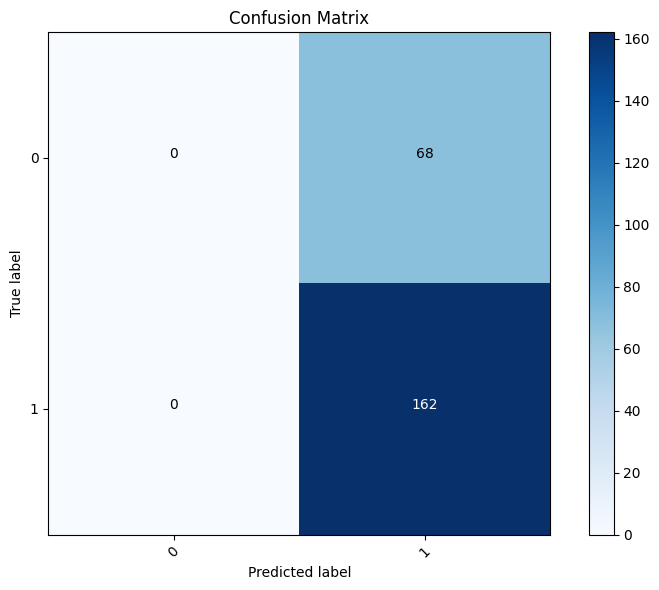

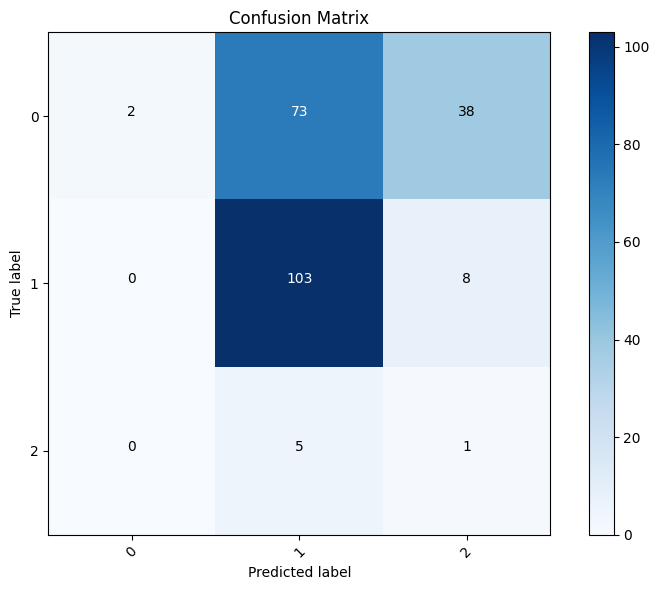

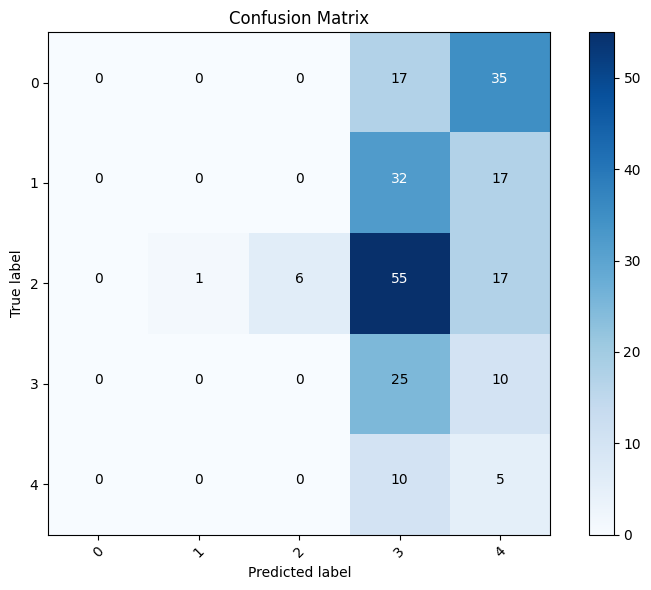

In [27]:
# Use the trained meta-model to make predictions on the test set
y_presence_test1_pred = base_models[0].predict(X_presence_test1)
y_occupancy_test1_pred = base_models[1].predict(X_occupancy_test1)
y_counting_test1_pred = base_models[2].predict(X_counting_test1)

# Convert the predicted probabilities to class labels
y_presence_test1_pred_class = pd.DataFrame(np.argmax(y_presence_test1_pred, axis=1))
y_occupancy_test1_pred_class = pd.DataFrame(np.argmax(y_occupancy_test1_pred, axis=1))
y_counting_test1_pred_class = pd.DataFrame(np.argmax(y_counting_test1_pred, axis=1))

# generate the confusion matrix
cm1 = confusion_matrix(y_presence_test1.astype(int), y_presence_test1_pred_class.astype(int))
cm2 = confusion_matrix(y_occupancy_test1.astype(int), y_occupancy_test1_pred_class.astype(int))
cm3 = confusion_matrix(y_counting_test1.astype(int), y_counting_test1_pred_class.astype(int))

# plot the confusion matrix for presense
plt.figure(figsize=(8, 6))
plt.imshow(cm1, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = np.unique(y_presence_test1)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm1.max() / 2.
for i in range(cm1.shape[0]):
    for j in range(cm1.shape[1]):
        plt.text(j, i, format(cm1[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm1[i, j] > thresh else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show() 

# plot the confusion matrix for occupancy
plt.figure(figsize=(8, 6))
plt.imshow(cm2, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = np.unique(y_occupancy_test1)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm2.max() / 2.
for i in range(cm2.shape[0]):
    for j in range(cm2.shape[1]):
        plt.text(j, i, format(cm2[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm2[i, j] > thresh else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show() 

# plot the confusion matrix for counting
plt.figure(figsize=(8, 6))
plt.imshow(cm3, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = np.unique(y_counting_test1)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm3.max() / 2.
for i in range(cm3.shape[0]):
    for j in range(cm3.shape[1]):
        plt.text(j, i, format(cm3[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm3[i, j] > thresh else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show() 

#### Preprocessing x and y outputs


In [106]:
X_presence_train_pred = pd.DataFrame(base_models[0].predict(X_presence_train))
X_presence_val_pred = pd.DataFrame(base_models[0].predict(X_presence_val))
X_presence_test1_pred = pd.DataFrame(base_models[0].predict(X_presence_test1))

X_occupancy_train_pred = pd.DataFrame(base_models[1].predict(X_occupancy_train))
X_occupancy_val_pred = pd.DataFrame(base_models[1].predict(X_occupancy_val))
X_occupancy_test1_pred = pd.DataFrame(base_models[1].predict(X_occupancy_test1))

X_counting_train_pred = pd.DataFrame(base_models[2].predict(X_counting_train))
X_counting_val_pred = pd.DataFrame(base_models[2].predict(X_counting_val))
X_counting_test1_pred = pd.DataFrame(base_models[2].predict(X_counting_test1))

X_train = pd.concat([X_presence_train_pred, X_occupancy_train_pred, X_counting_train_pred], axis = 1)
X_val = pd.concat([X_presence_val_pred, X_occupancy_val_pred, X_counting_val_pred], axis = 1)
X_test1 = pd.concat([X_presence_test1_pred, X_occupancy_test1_pred, X_counting_test1_pred], axis = 1)

'''X_train = np.array(X_presence_train)
X_val = np.array(X_presence_val)
X_test1 =  np.array(X_presence_test1)'''

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test1 =  np.array(X_test1)

print(X_train.shape)
print(X_val.shape)
print(X_test1.shape)




1972/1972 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
(63078, 10)
(15770, 10)
(230, 10)


In [83]:
# Get the predicted probabilities for each model
y_presence_train_pred = base_models[0].predict(X_presence_train)
y_occupancy_train_pred = base_models[1].predict(X_occupancy_train)
y_counting_train_pred = base_models[2].predict(X_counting_train)

# Get the predicted probabilities for each model
y_presence_val_pred = base_models[0].predict(X_presence_val)
y_occupancy_val_pred = base_models[1].predict(X_occupancy_val)
y_counting_val_pred = base_models[2].predict(X_counting_val)

# Get the predicted probabilities for each model
y_presence_test1_pred = base_models[0].predict(X_presence_test1)
y_occupancy_test1_pred = base_models[1].predict(X_occupancy_test1)
y_counting_test1_pred = base_models[2].predict(X_counting_test1)

# Convert the predicted probabilities to class labels
y_presence_pred_train_class = pd.DataFrame(np.argmax(y_presence_train_pred, axis=1))
y_occupancy_pred_train_class = pd.DataFrame(np.argmax(y_occupancy_train_pred, axis=1))
y_counting_pred_train_class = pd.DataFrame(np.argmax(y_counting_train_pred, axis=1))

# Convert the predicted probabilities to class labels
y_presence_pred_val_class = pd.DataFrame(np.argmax(y_presence_val_pred, axis=1))
y_occupancy_pred_val_class = pd.DataFrame(np.argmax(y_occupancy_val_pred, axis=1))
y_counting_pred_val_class = pd.DataFrame(np.argmax(y_counting_val_pred, axis=1))

# Convert the predicted probabilities to class labels
y_presence_pred_test1_class = pd.DataFrame(np.argmax(y_presence_test1_pred, axis=1))
y_occupancy_pred_test1_class = pd.DataFrame(np.argmax(y_occupancy_test1_pred, axis=1))
y_counting_pred_test1_class = pd.DataFrame(np.argmax(y_counting_test1_pred, axis=1))


1972/1972 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [85]:

y_train = pd.concat([y_presence_pred_train_class, y_occupancy_pred_train_class, y_counting_pred_train_class], axis = 1)
y_val = pd.concat([y_presence_pred_val_class, y_occupancy_pred_val_class, y_counting_pred_val_class], axis = 1)
y_test1 = pd.concat([y_presence_pred_test1_class, y_occupancy_pred_test1_class, y_counting_pred_test1_class], axis = 1)


In [108]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test1 = imputer.transform(X_test1)
# use variance threshold to remove features with low variances and scale the data
variance_threshold = VarianceThreshold(threshold=np.median(np.var(X_train, axis=0)))
scaler = StandardScaler()

# only fit train data and then transform all
for transformer in (scaler, variance_threshold):
    X_train = transformer.fit_transform(X_train)
    X_val = transformer.transform(X_val)
    X_test1 = transformer.transform(X_test1)

In [87]:
print (y_train)
print (y_train.shape)


y_train = np.array(y_train)
y_val = np.array(y_val)
y_test1 = np.array(y_test1)



       0  0  0
0      1  0  3
1      1  2  4
2      1  1  4
3      1  2  0
4      1  0  3
...   .. .. ..
63073  1  1  0
63074  1  0  1
63075  1  0  4
63076  1  1  0
63077  1  0  1

[63078 rows x 3 columns]
(63078, 3)


##### Weighted Average Solution

In [33]:

# Calculate the accuracy of each model
accuracy1 = accuracy_score(y_presence_train, y_presence_pred_train_class)
accuracy2 = accuracy_score(y_presence_val, y_presence_pred_val_class)
accuracy3 = accuracy_score(y_presence_test1, y_presence_pred_test1_class)

accuracy4 = accuracy_score(y_occupancy_train, y_occupancy_pred_train_class)
accuracy5 = accuracy_score(y_occupancy_val, y_occupancy_pred_val_class)
accuracy6 = accuracy_score(y_occupancy_test1, y_occupancy_pred_test1_class)

accuracy7 = accuracy_score(y_counting_train, y_counting_pred_train_class)
accuracy8 = accuracy_score(y_counting_val, y_counting_pred_val_class)
accuracy9 = accuracy_score(y_counting_test1, y_counting_pred_test1_class)

print(accuracy1)
print(accuracy2)
print(accuracy3)
print(accuracy4)
print(accuracy5)
print(accuracy6)
print(accuracy7)
print(accuracy8)
print(accuracy9)

0.9466057896572497
0.9330374128091312
0.7043478260869566
0.813310504454802
0.753138871274572
0.4608695652173913
0.6784298804654555
0.6016487000634115
0.1565217391304348


In [58]:

y_train_weights = [accuracy1 / (accuracy1 + accuracy4 + accuracy7), accuracy4 / (accuracy1 + accuracy4 + accuracy7), accuracy7 / (accuracy1 + accuracy4 + accuracy7)]
y_val_weights = [accuracy2 / (accuracy2 + accuracy5 + accuracy8), accuracy5 / (accuracy2 + accuracy5 + accuracy8), accuracy8 / (accuracy2 + accuracy5 + accuracy8)]
y_test1_weights = [accuracy3 / (accuracy3 + accuracy6 + accuracy9), accuracy6 / (accuracy3 + accuracy6 + accuracy9), accuracy9 / (accuracy3 + accuracy6 + accuracy9)]


#Calculate the weighted average of the predictions for each model
y_train_weighted_pred = (y_train_weights[0] * y_presence_pred_train_class + y_train_weights[1] * y_occupancy_pred_train_class + y_train_weights[2] * y_counting_pred_train_class) / sum(y_train_weights)
y_val_weighted_pred = (y_val_weights[0] * y_presence_pred_val_class + y_val_weights[1] * y_occupancy_pred_val_class + y_val_weights[2] * y_counting_pred_val_class)/ sum(y_val_weights)
y_test1_weighted_pred = (y_test1_weights[0] * y_presence_pred_test1_class + y_test1_weights[1] * y_occupancy_pred_test1_class + y_test1_weights[2] * y_counting_pred_test1_class) / sum(y_test1_weights)


print("weights:")
print(y_train_weights)
print(y_val_weights)
print(y_test1_weights)
    
print ("weighted preds:")
print(y_train_weighted_pred)
print(y_val_weighted_pred)
print(y_test1_weighted_pred)

y_train_weighted_pred = np.array(y_train_weighted_pred)
y_val_weighted_pred = np.array(y_val_weighted_pred)
y_test1_weighted_pred = np.array(y_test1_weighted_pred)

train_labels =[]
for row in y_train_weighted_pred:
    if row < 0.670319:  # adjust the threshold as needed
        train_labels.append(0)
    elif row < 0.72739:  # adjust the threshold as needed
        train_labels.append(1)
    elif row < 1.55310:  # adjust the threshold as needed
        train_labels.append(2)
    elif row < 2.15932:  # adjust the threshold as needed
        train_labels.append(3)
    else:
        train_labels.append(4)


val_labels =[]
for row in y_val_weighted_pred:
    if row < 0.670319:  # adjust the threshold as needed
        val_labels.append(0)
    elif row <  0.72739:  # adjust the threshold as needed
        val_labels.append(1)
    elif row < 1.55310:  # adjust the threshold as needed
        val_labels.append(2)
    elif row <=  2.15932:  # adjust the threshold as needed
        val_labels.append(3)
    else:
        val_labels.append(4)

test1_labels =[]
for row in y_test1_weighted_pred:
    if row <=  0.651315:  # adjust the threshold as needed
        test1_labels.append(0)
    elif row <=  1.11842:  # adjust the threshold as needed
        test1_labels.append(1)
    elif row <= 1.236841:  # adjust the threshold as needed
        test1_labels.append(2)
    elif row <=  1.703946:  # adjust the threshold as needed
        test1_labels.append(3)
    else:
        test1_labels.append(4)



# Convert the probabilities to a numpy array
y_train_final = np.array(train_labels)
print(y_train_final.shape)
y_val_final = np.array(val_labels)
print(y_val_final.shape)
y_test1_final = np.array(test1_labels)
print(y_test1_final.shape)


weights:
[0.3882163244606842, 0.3335500565647634, 0.27823361897455234]
[0.40782726793979873, 0.32919426813381747, 0.26297846392638374]
[0.5328947368421053, 0.3486842105263158, 0.11842105263157897]
weighted preds:
              0
0      1.222917
1      2.168251
2      1.834701
3      1.055316
4      1.222917
...         ...
63073  0.721766
63074  0.666450
63075  1.501151
63076  0.721766
63077  0.666450

[63078 rows x 1 columns]
              0
0      1.118130
1      1.000000
2      1.525957
3      2.118130
4      1.525957
...         ...
15765  1.196763
15766  1.525957
15767  0.670806
15768  0.737022
15769  0.670806

[15770 rows x 1 columns]
            0
0    1.236842
1    1.236842
2    1.355263
3    1.236842
4    1.236842
..        ...
225  1.703947
226  1.355263
227  1.236842
228  1.236842
229  1.236842

[230 rows x 1 columns]
(63078,)
(15770,)
(230,)


##### combination of predictions simple logic

In [68]:

# Initialize a list to store the probabilities
classes_train = []
classes_val = []
classes_test1 = []


y_train = np.array(y_train)
y_val = np.array(y_val)
y_test1 = np.array(y_test1)

def label_data(row):
    if row[0] == 0:
        return 0
    elif row[0] == 1 and row[1] == 0:
        return 1
    elif (row[0] == 1 and row[1] == 1 and row[2] in [0, 1, 2]) or (row[0] == 1 and row[1] == 1 and row[2] in [3, 4]):
        return 2
    elif (row[0] == 1 and row[1] == 1 and row[2] in [3, 4]):
        return 3
    else:
        return 4

classes_train = [label_data(row) for row in y_train]
classes_val = [label_data(row) for row in y_val]
classes_test1 = [label_data(row) for row in y_test1]

y_train_final = np.array(classes_train)
y_val_final = np.array(classes_val)
y_test1_final = np.array(classes_test1)


#### prints

[1 4 2 ... 1 2 1]
[0 2 2 ... 1 2 1]
[2 2 2 2 2 2 2 2 2 4 2 2 2 2 4 4 2 4 4 4 2 2 2 2 4 2 2 2 2 2 2 4 2 2 4 2 2
 2 2 2 2 4 2 2 2 4 2 2 4 2 2 2 2 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 1 2
 4 4 2 2 2 2 2 2 2 4 2 4 2 4 2 2 4 2 2 2 2 4 2 2 2 2 4 2 2 4 2 2 2 4 2 2 2
 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 4 2 2 2 4 2 2 2 2 4 2 4 2 4 2 2 2 2 4 2 2
 2 2 2 2 4 2 2 4 4 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 4 2 4 4 2 2 2 2
 4 2 2 2 2 2 4 1 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2
 2 4 2 4 2 2 2 2]
(63078,)
(15770,)
(230,)
(63078, 10)
(15770, 10)
(230, 10)


Text(0.5, 1.0, 'Data Distribution')

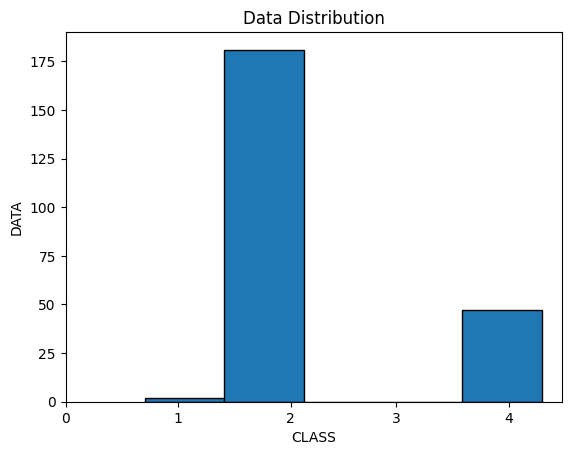

In [136]:

print(y_train_final)
print(y_val_final)
print(y_test1_final)

print(y_train_final.shape)
print(y_val_final.shape)
print(y_test1_final.shape)

print(X_train.shape)
print(X_val.shape)
print(X_test1.shape)

labels= ['0','1','2','3','4']
plt.hist(y_test1_final, bins=5, edgecolor='black')# bins is the number of bins you want to divide the data into
plt.xticks([0.4, 1.25, 2.1, 2.9, 3.75], labels) # Set the x-axis ticks at the center of bins  
plt.xlabel('CLASS')
plt.ylabel('DATA')
plt.title('Data Distribution')



#### Train and Evaluate

In [125]:

input_shape = (y_train.shape[1],)
output_shape = len(np.unique(y_counting))

print(output_shape)
print(input_shape)

5
(3,)


In [134]:

# Define the meta-model architecture
meta_model = Sequential()
meta_model.add(Dense(120, input_shape=input_shape, activation='relu'))
#meta_model.add(Dropout(0.3))
meta_model.add(BatchNormalization())
meta_model.add(Dense(90, activation='relu'))
#meta_model.add(Dropout(0.2))
meta_model.add(BatchNormalization())
meta_model.add(Dense(output_shape, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

# Compile the meta-model
meta_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the meta-model
meta_history = meta_model.fit(Χ_train, y_counting_train, epochs=500,
                              validation_data=(Χ_val, y_counting_val), batch_size=512, callbacks=[early_stopping])

# Evaluate the meta-model
meta_loss, meta_accuracy = meta_model.evaluate(y_val, y_counting_val)
print(f"Meta-model performance: loss={meta_loss:.4f}, accuracy={meta_accuracy:.4f}")

# Use the trained meta-model to make predictions on the test set
y_test1_pred = meta_model.predict(Χ_test1)

# Convert the predicted probabilities to class labels
y_test1_pred_class = pd.DataFrame(np.argmax(y_test1_pred, axis=1))

# Evaluate the performance of the meta-model on the test set
test_loss, test_accuracy = meta_model.evaluate(Χ_test1, y_counting_test1)
print(f"Meta-model performance on test set: loss={test_loss:.4f}, accuracy={test_accuracy:.4f}")

Epoch 1/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6135 - loss: 1.0828 - val_accuracy: 0.3096 - val_loss: 1.5189
Epoch 2/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6767 - loss: 0.9330 - val_accuracy: 0.3816 - val_loss: 1.3345
Epoch 3/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6773 - loss: 0.9253 - val_accuracy: 0.5350 - val_loss: 1.1796
Epoch 4/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6778 - loss: 0.9230 - val_accuracy: 0.5577 - val_loss: 1.1409
Epoch 5/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6762 - loss: 0.9267 - val_accuracy: 0.6016 - val_loss: 1.1207
Epoch 6/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6800 - loss: 0.9200 - val_accuracy: 0.6016 - val_loss: 1.1201
Epoch 7/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6774 - loss: 0.9241 - val_accuracy: 0.6016 - val_loss: 1.1372
Epoch 8/500
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6806 - loss: 0.9182 - val_acc

### FNN Plots and Cofusion Matrix

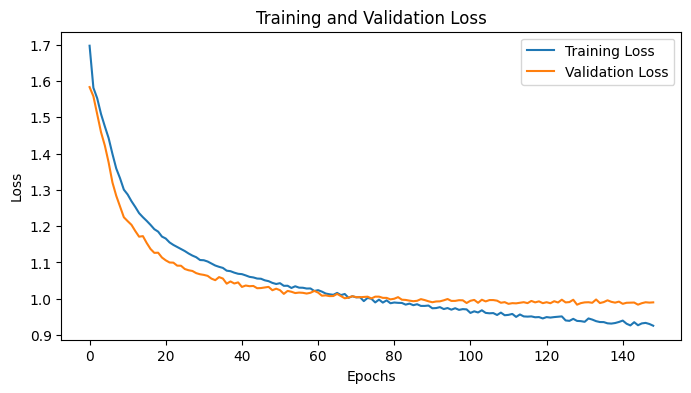

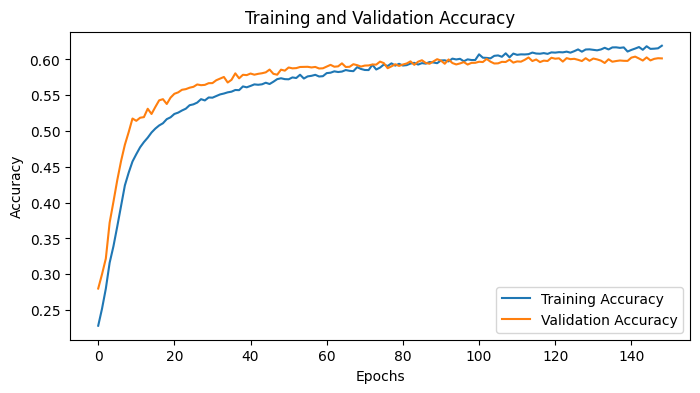

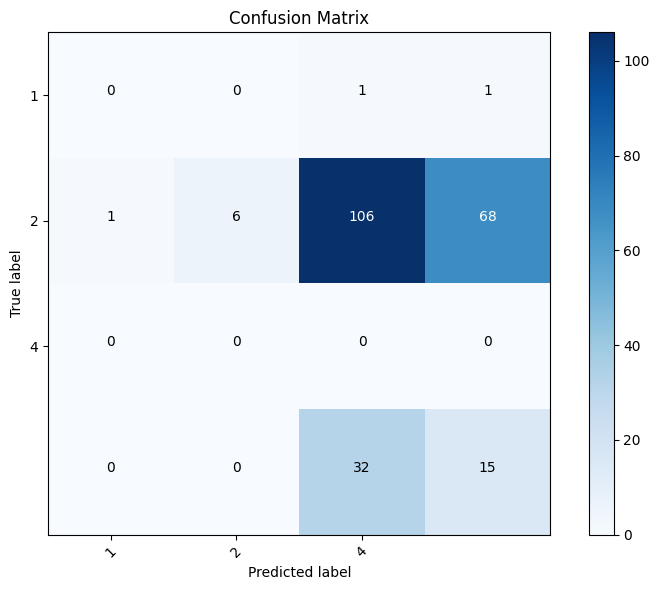

In [135]:

# plot the training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# plot the training and validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


# generate the confusion matrix
cm = confusion_matrix(y_test1_final.astype(int), y_test1_pred_class.astype(int))

# plot the confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = np.unique(y_test1_final)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show() 


